In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from sklearn.model_selection import train_test_split
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm

# 1.Configuration

In [ ]:
# All major settings are here for easy modification
DATA_DIR = "content"
ZIP_FILE = os.path.join(DATA_DIR, 'faces_224.zip')
METADATA_FILE = os.path.join(DATA_DIR, 'metadata.csv')
IMAGE_DIR = os.path.join(DATA_DIR, 'faces_224')
MODEL_SAVE_PATH = "deepfake_detector_dual_branch.pth"

# Model and training settings
IMG_SIZE = 224
HANDCRAFTED_FEATURE_DIM = 262
BATCH_SIZE = 32
LEARNING_RATE_HEAD = 1e-3
LEARNING_RATE_FT = 1e-5
EPOCHS_HEAD = 10
EPOCHS_FT = 15
PATIENCE = 3

# 2. Data Preparation

In [15]:
if not os.path.exists(IMAGE_DIR):
    print("Unzipping dataset...")
    with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)
    print("Unzipping complete.")
else:
    print("Image directory already exists.")

Image directory already exists.


# 3. Handcrafted Feature Extractor

In [16]:
def extract_features(image: np.ndarray) -> np.ndarray:
    """
    Extracts a fixed-size vector of 262 handcrafted features from an image.
    These features provide explicit information about color, texture, and edges.
    """
    # Ensure image is in 8-bit format for OpenCV functions
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    # 1. Color Histogram (3x6x6 = 216 features)
    hist = cv2.calcHist([image], [0, 1, 2], None, [6, 6, 6], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    color_hist = hist.flatten()

    # Convert to grayscale for texture and edge features
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 2. Edge Features (16 features)
    edges = cv2.Canny(gray, 100, 200)
    edge_hist = cv2.calcHist([edges], [0], None, [16], [0, 256])
    cv2.normalize(edge_hist, edge_hist)
    edge_hist = edge_hist.flatten()

    # 3. LBP Texture Features (10 features)
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    lbp_hist = lbp_hist.astype(np.float32)
    lbp_hist /= (lbp_hist.sum() + 1e-6) # Normalize

    # 4. Statistical Features (20 features)
    mean, std_dev = cv2.meanStdDev(gray)
    stat_features = [np.mean(gray), np.std(gray), np.median(gray), np.percentile(gray, 25), np.percentile(gray, 75)]
    h = gray.shape[0]
    regions = [gray[:h//3], gray[h//3:2*h//3], gray[2*h//3:]]
    for region in regions:
        stat_features.extend([np.mean(region), np.std(region), np.median(region), np.percentile(region, 25), np.percentile(region, 75)])
    stat_features = np.array(stat_features, dtype=np.float32)

    # Combine all features into a single vector
    return np.concatenate([color_hist, edge_hist, lbp_hist, stat_features])

# 4. Dual-Branch Model

In [17]:
class DualBranchEfficientNet(nn.Module):
    def __init__(self, feature_dim=HANDCRAFTED_FEATURE_DIM, pretrained=True):
        super().__init__()
        # --- Image Branch Backbone ---
        weights = EfficientNet_B0_Weights.DEFAULT if pretrained else None
        backbone = efficientnet_b0(weights=weights)
        self.cnn = backbone.features
        num_cnn_features = backbone.classifier[1].in_features  # 1280 for B0

        # Freeze the CNN backbone initially for transfer learning
        if pretrained:
            for param in self.cnn.parameters():
                param.requires_grad = False

        # --- Image Branch Head ---
        # Processes features extracted by the CNN
        self.img_fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.BatchNorm1d(num_cnn_features),
            nn.Linear(num_cnn_features, 512),
            nn.ReLU(),
            nn.Dropout(0.4)
        )

        # --- Handcrafted Feature Branch ---
        # Processes the manually extracted feature vector
        self.feat_fc = nn.Sequential(
            nn.BatchNorm1d(feature_dim),
            nn.Linear(feature_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # --- Combined Classifier ---
        # Fuses information from both branches for the final decision
        self.classifier = nn.Sequential(
            nn.Linear(512 + 128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, image, features):
        # Process image through CNN branch
        x = self.cnn(image)
        x = self.img_fc(x)

        # Process handcrafted features through its branch
        y = self.feat_fc(features)

        # Combine the outputs and classify
        combined = torch.cat((x, y), dim=1)
        out = self.classifier(combined)
        return out

# 5. Dataset

In [19]:
class DeepFakeDataset(Dataset):
    def __init__(self, dataframe, image_dir):
        self.dataframe = dataframe
        self.image_dir = image_dir

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_filename = row['videoname'].replace('.mp4', '.jpg')
        img_path = os.path.join(self.image_dir, img_filename)

        try:
            # Load and preprocess image
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

            # Get handcrafted features BEFORE normalization
            handcrafted_features = extract_features(image)
            handcrafted_features = torch.from_numpy(handcrafted_features.astype(np.float32))

            # Normalize image for the CNN
            image = image.astype(np.float32) / 255.0
            image = torch.from_numpy(image).permute(2, 0, 1)

            label = 1 if row['label'] == 'FAKE' else 0
            label = torch.tensor(label, dtype=torch.float32)

            return image, handcrafted_features, label

        except Exception as e:
            # Return dummy data if an error occurs
            return torch.zeros((3, IMG_SIZE, IMG_SIZE)), torch.zeros(HANDCRAFTED_FEATURE_DIM), torch.tensor(0.0)


# 6. Training and Validation Code

In [18]:
def run_epoch(model, loader, optimizer, criterion, is_training, device):
    """Runs a single epoch of training or validation."""
    model.train(is_training) # Set model to training or evaluation mode
    total_loss, total_correct, total_samples = 0.0, 0, 0
    
    # Add a progress bar for better user experience
    pbar = tqdm(loader, desc="Training" if is_training else "Validation")

    for images, features, labels in pbar:
        images, features, labels = images.to(device), features.to(device), labels.to(device).unsqueeze(1)

        with torch.set_grad_enabled(is_training):
            outputs = model(images, features)
            loss = criterion(outputs, labels)

            if is_training:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        preds = (outputs > 0.5).float()
        total_loss += loss.item() * images.size(0)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

        # Update progress bar
        pbar.set_postfix(loss=total_loss/total_samples, acc=total_correct/total_samples)

    return total_loss / total_samples, total_correct / total_samples

# 7. Main Training

In [ ]:

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    df = pd.read_csv(METADATA_FILE)
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
    train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['label'])

    train_loader = DataLoader(DeepFakeDataset(train_df, IMAGE_DIR), batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(DeepFakeDataset(val_df, IMAGE_DIR), batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    test_loader = DataLoader(DeepFakeDataset(test_df, IMAGE_DIR), batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    model = DualBranchEfficientNet().to(device)
    criterion = nn.BCELoss()

    best_loss = float('inf')
    early_stop_counter = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # --- PHASE 1: Train Newly Added Layers ---
    print("\n--- Phase 1: Training Head Layers ---")
    # Optimize only the parameters that are not frozen
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE_HEAD)

    for epoch in range(EPOCHS_HEAD):
        print(f"\nEpoch {epoch+1}/{EPOCHS_HEAD}")
        train_loss, train_acc = run_epoch(model, train_loader, optimizer, criterion, True, device)
        val_loss, val_acc = run_epoch(model, val_loader, None, criterion, False, device)

        history['train_loss'].append(train_loss); history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= PATIENCE:
                print("Early stopping triggered in Phase 1.")
                break
    
    model.load_state_dict(best_model_wts)

    # --- PHASE 2: Fine-Tune the Full Model ---
    print("\n--- Phase 2: Fine-Tuning Full Model ---")
    # Unfreeze the CNN backbone for fine-tuning
    for param in model.cnn.parameters():
        param.requires_grad = True
    
    # Create a new optimizer for ALL parameters with a lower learning rate
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE_FT)
    
    for epoch in range(EPOCHS_FT):
        print(f"\nEpoch {epoch+1+EPOCHS_HEAD}/{EPOCHS_HEAD+EPOCHS_FT}")
        train_loss, train_acc = run_epoch(model, train_loader, optimizer, criterion, True, device)
        val_loss, val_acc = run_epoch(model, val_loader, None, criterion, False, device)
        
        history['train_loss'].append(train_loss); history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= PATIENCE:
                print("Early stopping triggered in Phase 2.")
                break

    model.load_state_dict(best_model_wts)

Image directory already exists.
Using device: cuda

--- Phase 1: Training Head Layers ---

Epoch 1/10


Validation: 100%|██████████| 479/479 [01:43<00:00,  4.62it/s, acc=0.833, loss=0.397]



Epoch 2/10


Validation: 100%|██████████| 479/479 [01:23<00:00,  5.71it/s, acc=0.842, loss=0.387]



Epoch 3/10


Validation: 100%|██████████| 479/479 [01:31<00:00,  5.26it/s, acc=0.84, loss=0.387] 



Epoch 4/10


Validation: 100%|██████████| 479/479 [01:31<00:00,  5.23it/s, acc=0.841, loss=0.387]



Epoch 5/10


Validation: 100%|██████████| 479/479 [01:24<00:00,  5.67it/s, acc=0.849, loss=0.37] 



Epoch 6/10


Validation: 100%|██████████| 479/479 [01:24<00:00,  5.69it/s, acc=0.849, loss=0.392]



Epoch 7/10


Validation: 100%|██████████| 479/479 [01:23<00:00,  5.73it/s, acc=0.854, loss=0.364]



Epoch 8/10


Validation: 100%|██████████| 479/479 [01:22<00:00,  5.84it/s, acc=0.854, loss=0.355]



Epoch 9/10


Validation: 100%|██████████| 479/479 [01:24<00:00,  5.66it/s, acc=0.855, loss=0.359]



Epoch 10/10


Validation: 100%|██████████| 479/479 [01:24<00:00,  5.68it/s, acc=0.857, loss=0.352]



--- Phase 2: Fine-Tuning Full Model ---

Epoch 11/25


Validation: 100%|██████████| 479/479 [01:23<00:00,  5.70it/s, acc=0.869, loss=0.322]



Epoch 12/25


Validation: 100%|██████████| 479/479 [01:36<00:00,  4.94it/s, acc=0.876, loss=0.303]



Epoch 13/25


Validation: 100%|██████████| 479/479 [01:38<00:00,  4.88it/s, acc=0.882, loss=0.296]



Epoch 14/25


Validation: 100%|██████████| 479/479 [01:41<00:00,  4.73it/s, acc=0.885, loss=0.286]



Epoch 15/25


Validation: 100%|██████████| 479/479 [01:36<00:00,  4.96it/s, acc=0.886, loss=0.289]



Epoch 16/25


Validation: 100%|██████████| 479/479 [01:23<00:00,  5.74it/s, acc=0.891, loss=0.28] 



Epoch 17/25


Validation: 100%|██████████| 479/479 [01:26<00:00,  5.57it/s, acc=0.896, loss=0.269]



Epoch 18/25


Validation: 100%|██████████| 479/479 [01:26<00:00,  5.56it/s, acc=0.898, loss=0.268]



Epoch 19/25


Validation: 100%|██████████| 479/479 [01:30<00:00,  5.30it/s, acc=0.899, loss=0.27] 



Epoch 20/25


Validation: 100%|██████████| 479/479 [01:26<00:00,  5.54it/s, acc=0.901, loss=0.271]



Epoch 21/25


Validation: 100%|██████████| 479/479 [01:30<00:00,  5.30it/s, acc=0.9, loss=0.266]  



Epoch 22/25


Training:  23%|██▎       | 441/1913 [01:36<05:23,  4.55it/s, acc=0.946, loss=0.14] 


KeyboardInterrupt: 

# 8. Evaluation & Saving


--- Evaluating on Test Set ---


Validation: 100%|██████████| 598/598 [01:55<00:00,  5.16it/s, acc=0.901, loss=0.271]


Final Test Accuracy: 0.9008 | Final Test Loss: 0.2711

Model saved to deepfake_detector_dual_branch.pth


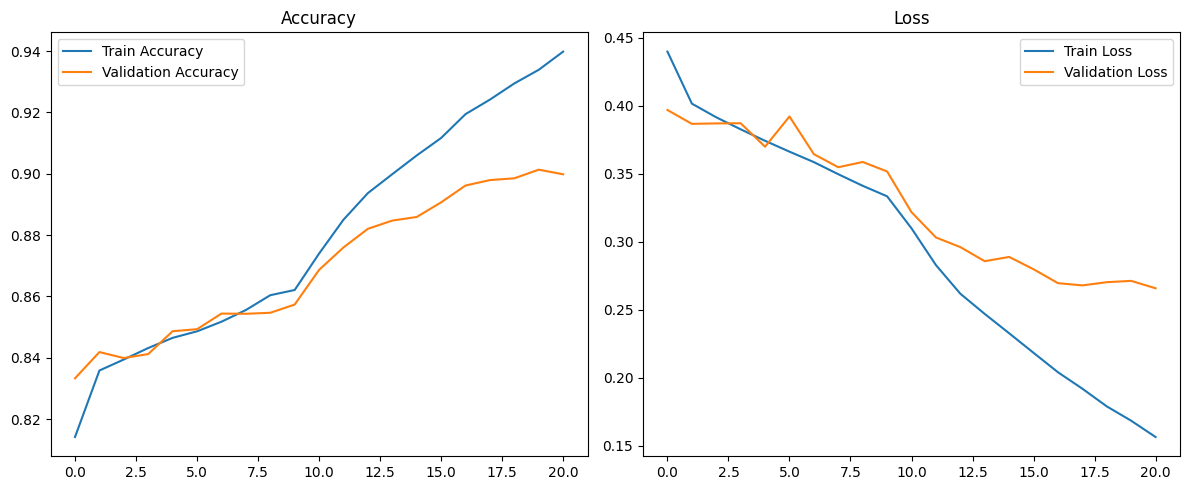

In [ ]:
print("\n--- Evaluating on Test Set ---")
test_loss, test_acc = run_epoch(model, test_loader, None, criterion, False, device)
print(f"Final Test Accuracy: {test_acc:.4f} | Final Test Loss: {test_loss:.4f}")

torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"\nModel saved to {MODEL_SAVE_PATH}")

# --- Plotting ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# 9. Predict Flow

In [13]:
MODEL_SAVE_PATH = "deepfake_detector_dual_branch.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DualBranchEfficientNet().to(device)
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
model.eval()


# --- Inference Function ---
def predict(image_path):
    IMG_SIZE = 224

    # Load and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

    # Extract handcrafted features
    handcrafted_features = extract_features(image)
    handcrafted_features = torch.from_numpy(handcrafted_features.astype(np.float32)).unsqueeze(0).to(device)

    # Normalize image for CNN
    image = image.astype(np.float32) / 255.0
    image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).to(device)

    # Forward pass
    with torch.no_grad():
        output = model(image, handcrafted_features)
        prob = output.item()
        label = "FAKE" if prob >= 0.5 else "REAL"
    
    return label, prob

In [14]:
img_path = "content/faces_224/aaagqkcdis.jpg"  # replace with your image path
label, prob = predict(img_path)
print(f"Prediction: {label} (confidence={prob:.4f})")

Prediction: FAKE (confidence=0.9992)


In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from sklearn.model_selection import train_test_split
from skimage.feature import local_binary_pattern
import matplotlib
import copy
from tqdm import tqdm

# --- Print versions ---
print("Python:", os.sys.version)
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("opencv (cv2):", cv2.__version__)
print("torch:", torch.__version__)
print("torchvision:", __import__('torchvision').__version__)
print("scikit-learn:", __import__('sklearn').__version__)
print("scikit-image:", __import__('skimage').__version__)
print("matplotlib:", matplotlib.__version__)
print("tqdm:", __import__('tqdm').__version__)


Python: 3.13.5 (main, Jun 21 2025, 09:35:00) [GCC 15.1.1 20250425]
pandas: 2.3.2
numpy: 2.2.6
opencv (cv2): 4.12.0
torch: 2.8.0+cu128
torchvision: 0.23.0+cu128
scikit-learn: 1.7.1
scikit-image: 0.25.2
matplotlib: 3.10.5
tqdm: 4.67.1
